In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Добавим директорию chapter03 в PYTHONPATH
sys.path.append(os.path.abspath(".."))

from models.linear_regression import linear_regression, predict
from utils.errors import mae, mse, rmse 
from utils.reporting import format_equation, print_prediction
from utils.plotting import draw_line, plot_points, plot_errors

## Простой подход для перемещения прямой ближе к набору точек, по одной точке за раз

Метод состоит в том, чтобы слегка повернуть и переместить прямую в направлении точки и тем самым сблизить их.  
Итак, вот четыре сценария:
| **📌 Сценарий** | **📍 Положение точки**       | **🔄 Направление вращения**      | **📤 Перемещение прямой** |
|--------------|---------------------------|-------------------------------|------------------------|
| 1            | 🔴**Над** прямой, 🟡**справа** от оси $Y$ | 🔵**Против** часовой стрелки       | ⏫Вверх                  |
| 2            | 🔴**Над** прямой, 🟣**слева** от оси $Y$  | 🟠**По** часовой стрелке           | ⏫Вверх                  |
| 3            | 🟢**Под** прямой, 🟡**справа** от оси $Y$ | 🟠**По** часовой стрелке           | ⬇️Вниз                   |
| 4            | 🟢**Под** прямой, 🟣**слева** от оси $Y$  | 🔵**Против** часовой стрелки       | ⬇️Вниз                   |

---
Уравнение прямой: $ y = m \cdot x + b $,

где
- $m$ — наклон;
- $b$ — $Y$-пересечение.

В примере с жильём использовали аналогичную нотацию:
- точка с координатами $(r, p)$ соответствует дому с $r$ комнатами и ценой $p$;
- наклон $m$ соответствует цене за комнату;
- $y$-пересечение $b$ соответствует базовой цене дома;
- прогноз $ \hat{p} = m \cdot r + b $ соответствует прогнозируемой цене дома

## Псевдокод для простого подхода

**Входные данные:**
1. линия с наклоном $m$, $Y$-пересечением $b$ и уравнением $ \hat{p} = m \cdot r + b $
2. точка с координатами $(r, p)$.

**Результат** — линия $ \hat{p} = m' \cdot r + b' $, которая ближе к точке.

---

**Процедура:**  
- Выберите два очень маленьких случайных числа и назовите их  $ \eta_1 $ и $ \eta_2 $ (греческая буква *«эта»*).

- **Сценарий 1.** Если точка находится 🔴**над** прямой и 🟡**справа** от оси $Y$, вращаем прямую 🔵**против** часовой стрелки и перемещаем ее ⏫**вверх**:
  1. ➕Добавляем $ \eta_1 $ к наклону $m$, получаем $ m' = m + \eta_1 $
  2. ➕Добавляем $ \eta_2 $ к $Y$-пересечению $b$, получаем $ b' = b + \eta_2 $

- **Сценарий 2.** Если точка находится 🔴**над** прямой и 🟣**слева** от оси $Y$, вращаем прямую 🟠**по** часовой стрелке и перемещаем ее ⏫**вверх**:
  1. ➖Вычитаем $ \eta_1 $ из наклона $m$, получаем $ m' = m - \eta_1 $  
  2. ➕Добавляем $ \eta_2 $ к $Y$-пересечению $b$, получаем $ b' = b + \eta_2 $  

- **Сценарий 3.** Если точка находится 🟢**под** прямой и 🟡**справа** от оси $Y$, вращаем прямую 🟠**по** часовой стрелке и перемещаем ее ⬇️**вниз**:
  1. ➖Вычитаем $ \eta_1 $ из наклона $m$, получаем $ m' = m - \eta_1 $  
  2. ➖Вычитаем $ \eta_2 $ из $Y$-пересечения $b$, получаем $ b' = b - \eta_2 $  

- **Сценарий 4.** Если точка находится 🟢**под** прямой и 🟣**слева** от оси $Y$, вращаем прямую 🔵**против** часовой стрелки и перемещаем ее ⬇️**вниз**:
  1. ➕Добавляем $ \eta_1 $ к наклону $m$, получаем $ m' = m + \eta_1 $  
  2. ➖Вычитаем $ \eta_2 $ из $Y$-пересечения $b$, получаем $ b' = b - \eta_2 $

**Возврат** — прямая $ \hat{p} = m' \cdot r + b' $

---

Поскольку координата $x$ — количество комнат, это число **не может быть отрицательным**.  
Таким образом, здесь важны только сценарии 1 и 3.

---

## Квадратический подход — более умный способ приблизить прямую к одной из точек

**Вывод 1: Корректировка смещения (Y-пересечения)**  
Если добавить разность $( p - \hat{p} )$ к смещению $( b )$, прямая будет двигаться к точке, так как:  
- $( p - \hat{p} > 0 $) (точка **выше** прямой) → смещение **увеличивается** (линия сдвигается вверх).  
- $( p - \hat{p} < 0 $) (точка **ниже** прямой) → смещение **уменьшается** (линия сдвигается вниз).  

Однако в машинном обучении шаги должны быть небольшими, поэтому вводится **скорость обучения** $( \eta )$:  
$$
b_{\text{новое}} = b + \eta \cdot (p - \hat{p})
$$


**Вывод 2: Корректировка наклона (веса признака)**  
Рассмотрим величину $( r \cdot (p - \hat{p}) )$:  
- **Положительна** в сценариях 1 и 4 (точка справа/слева и выше/ниже прямой).  
- **Отрицательна** в сценариях 2 и 3 (точка слева/справа и выше/ниже прямой).  

Таким образом, добавление $( \eta \cdot r \cdot (p - \hat{p}) )$ к наклону $( m )$ всегда приближает прямую к точке:  
$$
m_{\text{новое}} = m + \eta \cdot r \cdot (p - \hat{p})
$$

**Итоговые правила обновления:**
$$
\begin{cases}
m' = m + \eta \cdot r \cdot (p - \hat{p}), \\
b' = b + \eta \cdot (p - \hat{p}).
\end{cases}
$$

**Пояснение:**   
- $( \eta )$ (эта) — скорость обучения, малая константа (например, 0.01).  
- $( p - \hat{p} )$ — ошибка прогноза (разница между истинным и предсказанным значениями).  
- Множитель $( r )$ масштабирует влияние признака на корректировку.

## Псевдокод для квадратического подхода

**Входные данные:**
1. прямая с наклоном $m$, $Y$-пересечением $b$ и уравнением $ \hat{p} = m \cdot r + b $
2. точка с координатами $(r, p)$;
3. небольшое положительное значение (скорость обучения).

**Результат** — прямая $ \hat{p} = m' \cdot r + b' $, которая находится ближе к точке.

---

**Процедура:**  
- Добавляем $ \eta \cdot r \cdot (p - \hat{p}) $ к наклону $m$, получаем $ m' = m + \eta \cdot r \cdot (p - \hat{p}) $ (при этом прямая вращается).
- Добавляем $ \eta \cdot (p - \hat{p}) $ к $Y$-пересечению $b$, получаем $ b' = b + \eta \cdot (p - \hat{p}) $ (это перемещает прямую).

**Возврат** — прямая $ \hat{p} = m' \cdot r + b' $.

# Загрузка данных и построение их графика

In [3]:
# 1. Данные
features = np.array([1, 2, 3, 5, 6, 7])
labels = np.array([155, 197, 244, 356, 407, 448])

In [4]:
# 2. Обучение
trick = 'square'
error = 'rmse'

m, b, errors_list = linear_regression(features, labels, epochs=10000, trick = trick, error = error)

In [5]:
# 3. Отчётность
print("Уравнение прямой:", format_equation(m, b))
print(print_prediction(m, b, 4))  # для конкретного X = 4

Уравнение прямой: y = 50.49 * x + 99.31
Для 4 комнат → Предсказанная цена: 301.28


In [6]:
# 4. Прогнозы + метрика
predictions = np.array([predict(m, b, r) for r in features])

print(f"MAE: \t {mae(labels, predictions):.2f}")
print(f"MSE: \t {mse(labels, predictions):.2f}")
print(f"RMSE: \t {rmse(labels, predictions):.2f}")

MAE: 	 4.83
MSE: 	 24.48
RMSE: 	 4.95


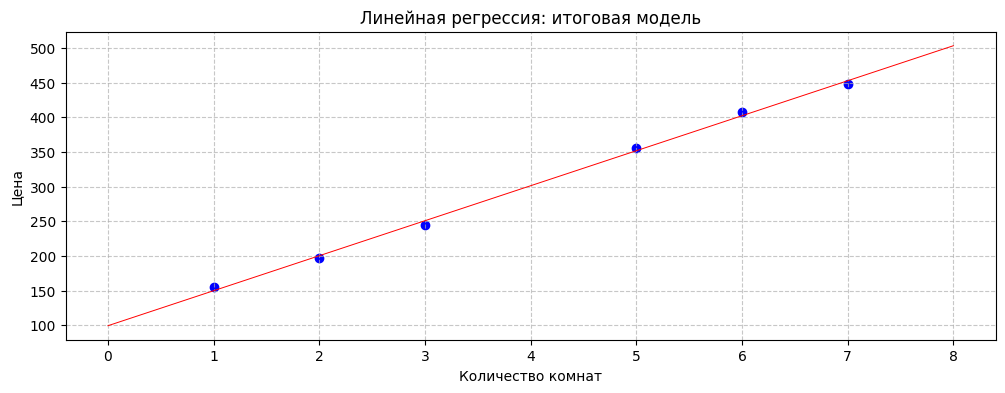

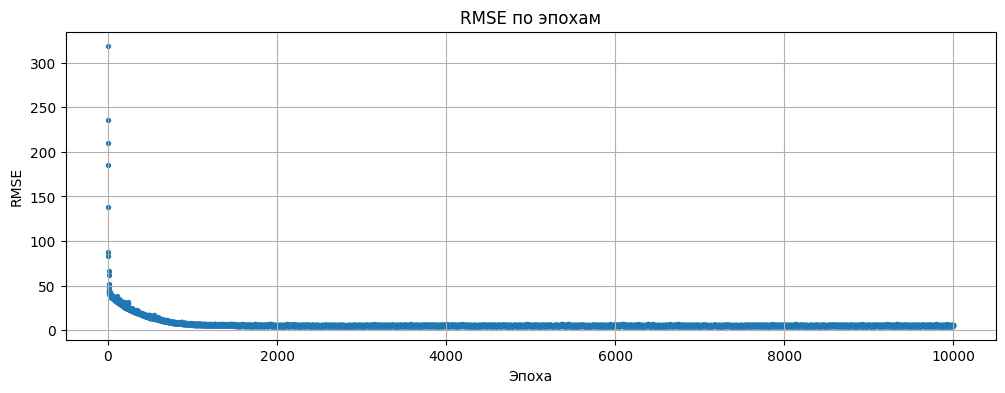

In [7]:
# 5. Визуализация
plt.figure(figsize=(12, 4))
draw_line(m, b)
plot_points(features, labels)
plt.title("Линейная регрессия: итоговая модель")
plt.show()

plt.figure(figsize=(12, 4))
plot_errors(errors_list, error)
plt.show()

# 🔁 Сравнение всех комбинаций
*Поиск оптимального сочетания метода обновления весов (trick), режима обучения (mode) и метрики ошибки (error).*

In [8]:
# 1. Данные
features = np.array([1, 2, 3, 5, 6, 7])
labels = np.array([155, 197, 244, 356, 407, 448])

In [9]:
# 2. Глобальные параметры
tricks = ['simple', 'absolute', 'square']
modes = ['sgd', 'batch', 'mini']
errors = ['mae', 'mse', 'rmse']

epochs = 3000
learning_rate = 0.01

In [10]:
# 3. Сравнение всех комбинаций

results = {}

for trick in tricks:
    results[trick] = {}
    for error in errors:
        results[trick][error] = {}
        for mode in modes:
            m, b, errors_list = linear_regression(
                features,
                labels,
                learning_rate=learning_rate,
                epochs=epochs,
                trick=trick,
                error=error,
                mode=mode,
                batch_size=2
            )
            predictions = np.array([predict(m, b, r) for r in features])
            results[trick][error][mode] = {
                'm': m,
                'b': b,
                'errors_list': errors_list,
                'mae': mae(labels, predictions),
                'mse': mse(labels, predictions),
                'rmse': rmse(labels, predictions)
            }

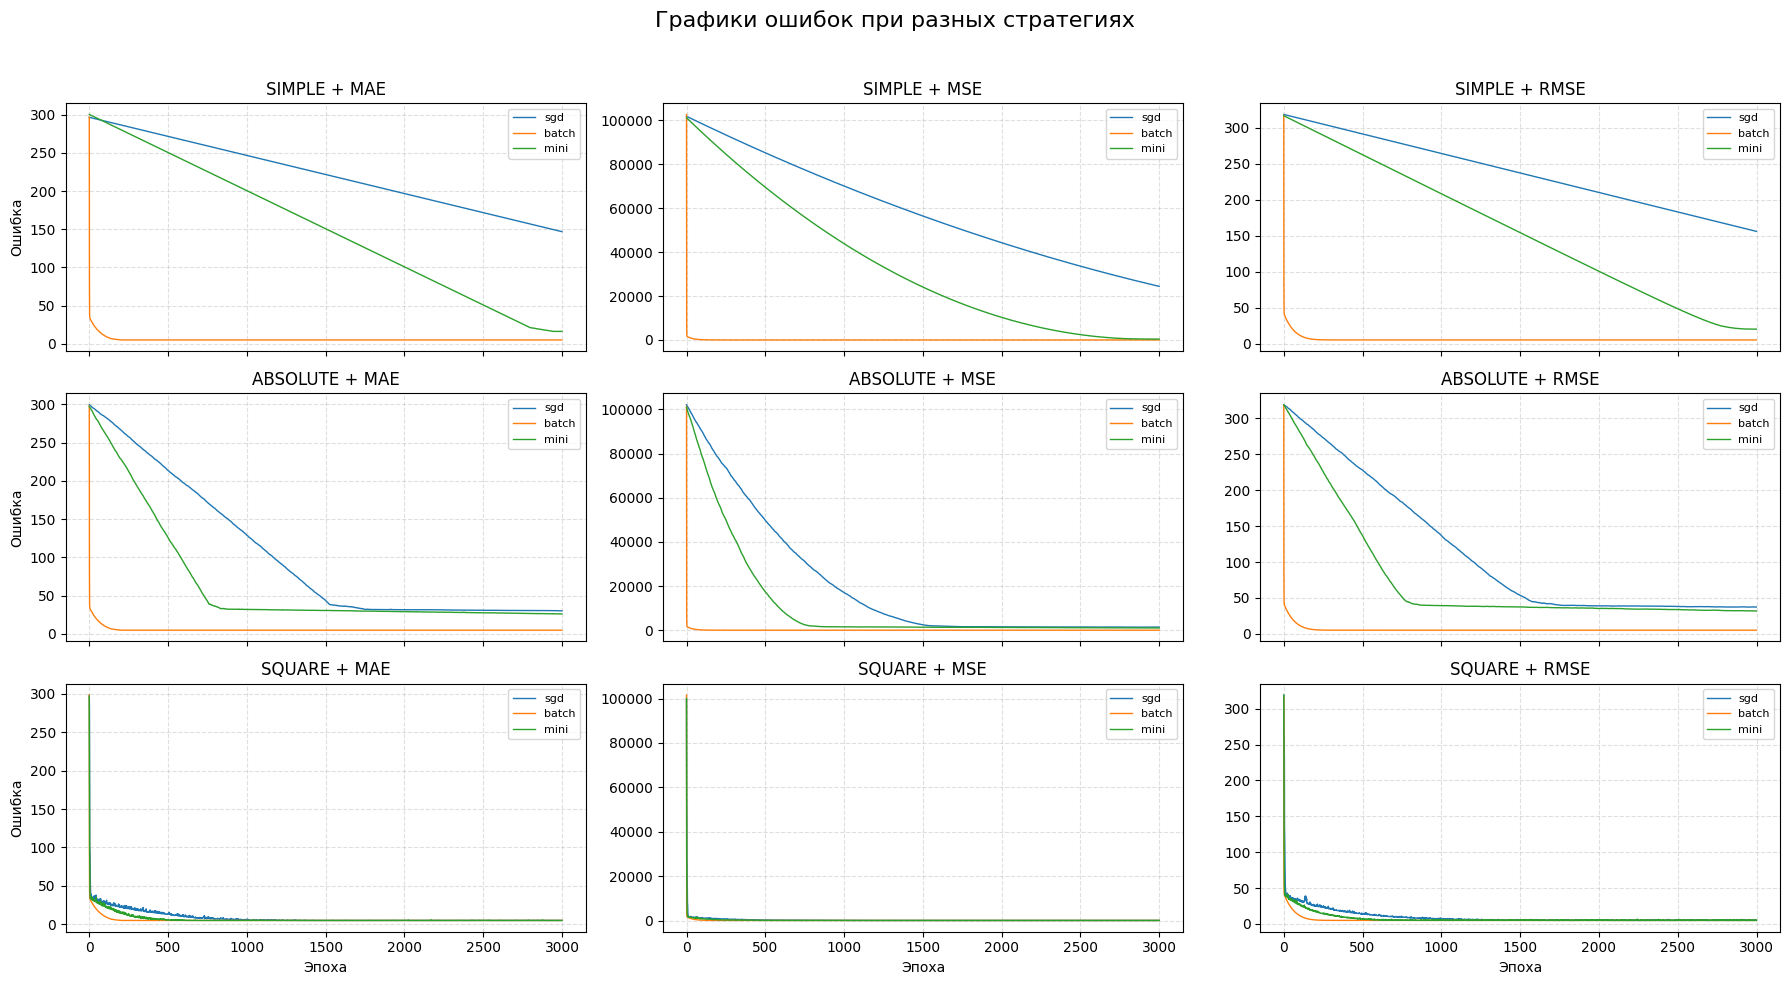

In [11]:
# 4. Визуализация ошибок (Error Curves)
fig, axs = plt.subplots(len(tricks), len(errors), figsize=(18, 10), sharex=True)#, sharey=True)
fig.suptitle("Графики ошибок при разных стратегиях", fontsize=16)

for i, trick in enumerate(tricks):
    for j, error in enumerate(errors):
        ax = axs[i, j]
        for mode in modes:
            ax.plot(results[trick][error][mode]['errors_list'], label=mode, linewidth=1)
        ax.set_title(f"{trick.upper()} + {error.upper()}")
        ax.grid(True, linestyle='--', alpha=0.4)
        if j == 0:
            ax.set_ylabel("Ошибка")
        if i == len(tricks) - 1:
            ax.set_xlabel("Эпоха")
        ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

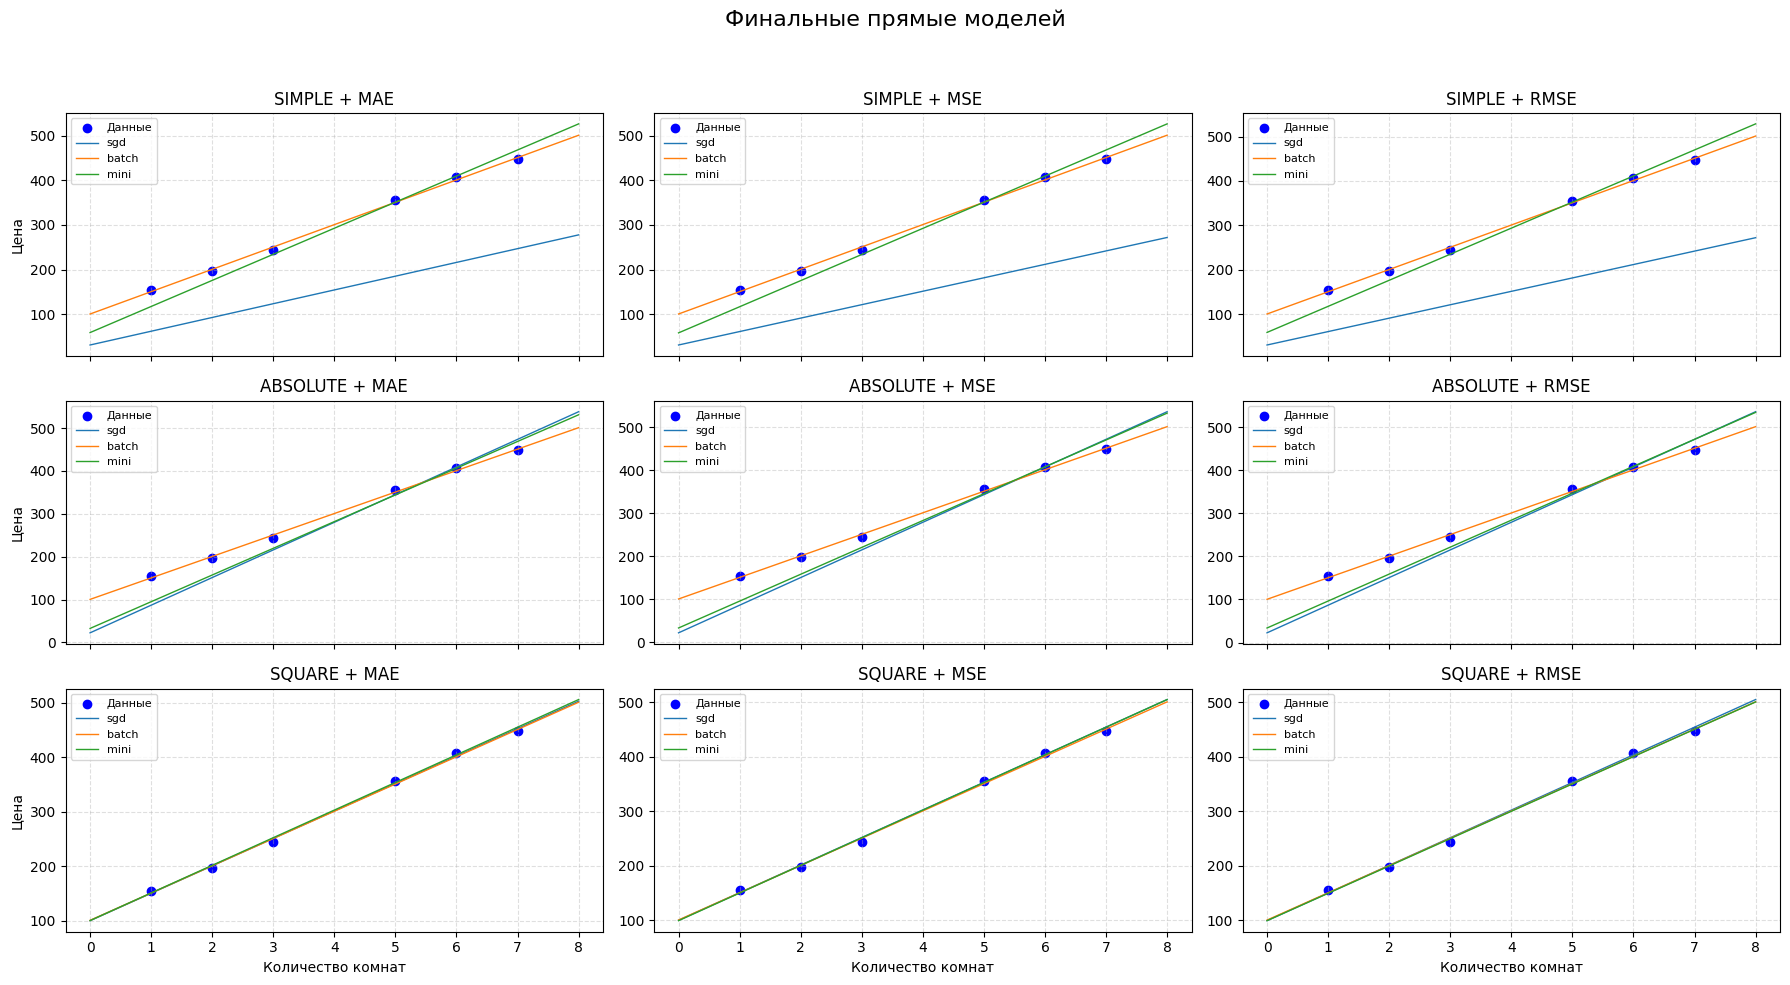

In [12]:
# 5. Визуализация моделей (Regression Lines)
fig, axs = plt.subplots(len(tricks), len(errors), figsize=(18, 10), sharex=True)
fig.suptitle("Финальные прямые моделей", fontsize=16)

x_range = np.linspace(0, 8, 100)

for i, trick in enumerate(tricks):
    for j, error in enumerate(errors):
        ax = axs[i, j] if len(tricks) > 1 else axs[j]
        
        # 1. Отобразим исходные точки
        ax.scatter(features, labels, color='blue', label='Данные')

        # 2. Отобразим прямые всех режимов
        for mode in modes:
            m = results[trick][error][mode]['m']
            b = results[trick][error][mode]['b']
            y_range = m * x_range + b
            ax.plot(x_range, y_range, label=mode, linewidth=1)

        # 3. Оформление графика
        ax.set_title(f"{trick.upper()} + {error.upper()}")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(fontsize=8)
        
        if j == 0:
            ax.set_ylabel("Цена")
        if i == len(tricks) - 1:
            ax.set_xlabel("Количество комнат")
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [13]:
# 6. Сравнительная таблица ошибок
table = []

for trick in tricks:
    for error in errors:
        for mode in modes:
            row = {
                "Trick": trick,
                "Error Metric": error,
                "Mode": mode,
                "MAE": round(results[trick][error][mode]["mae"], 2),
                "MSE": round(results[trick][error][mode]["mse"], 2),
                "RMSE": round(results[trick][error][mode]["rmse"], 2),
            }
            table.append(row)

df_results = pd.DataFrame(table)
df_results.sort_values(by=["RMSE"]).reset_index(drop=True)

,Trick,Error Metric,Mode,MAE,MSE,RMSE
0,square,mae,sgd,4.83,24.47,4.95
1,simple,mae,batch,4.83,25.03,5.00
2,simple,rmse,batch,4.83,25.03,5.00
3,simple,mse,batch,4.83,25.03,5.00
4,absolute,mse,batch,4.83,25.03,5.00
5,square,mae,batch,4.83,25.03,5.00
6,absolute,rmse,batch,4.83,25.03,5.00
7,absolute,mae,batch,4.83,25.03,5.00
8,square,mse,batch,4.83,25.03,5.00
9,square,rmse,batch,4.83,25.03,5.00


In [14]:
df_results.to_excel('results.xlsx')

# 📊 Общий финальный вывод:  
**Лучшее сочетание:**
 - ✅ **Trick:** square  
 - ✅ **Mode:** batch (или mini-batch)  
 - ✅ **Error metric:** неважно (mae / mse / rmse схожи при хорошем обучении)  

**Общая тенденция:**
 - square $> ($ absolute $≈$ simple $)$
 - batch $>$ mini-batch $>$ sgd

# Линейная регрессия с использованием библиотеки Scikit-Learn

In [15]:
# Импортируем класс LinearRegression из библиотеки sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
# Преобразуем массив признаков (features) в двумерный формат.
# Scikit-Learn требует, чтобы входные признаки были в виде матрицы (n образцов × m признаков),
# даже если у нас всего один признак.
features_reshaped = features.reshape(-1, 1)

In [17]:
# Создаём объект модели линейной регрессии
model = LinearRegression()

# Обучаем модель на наших данных (признаки + правильные ответы)
# Модель подберёт такие коэффициенты, чтобы минимизировать сумму квадратических ошибок (RSS, а не MSE)
model.fit(features_reshaped, labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Почему в LinearRegression минимизируется RSS, а не MSE?
 - Математически минимизация RSS эквивалентна минимизации MSE (так как MSE = RSS/n, где n - константа)
 - Scikit-learn использует численные методы оптимизации, где работают с RSS (не нужно делить на n)
 - Результат (оптимальные коэффициенты) будет одинаков в обоих случаях

## Где хранится значение RSS?
В scikit-learn RSS не сохраняется как атрибут модели после обучения. Его нужно вычислять вручную, как показано ниже.

Вывод будет содержать все основные метрики оценки регрессии:
 - RSS (общая сумма квадратов ошибок)
 - MSE (среднеквадратичная ошибка)
 - RMSE (корень из MSE)
 - SAE (сумма абсолютных ошибок)
 - MAE (средняя абсолютная ошибка)

In [18]:
# Получим предсказания модели
predicted_labels = model.predict(features_reshaped)

n_samples = len(labels)

# Расчет RSS и SAE
rss = round(((labels - predicted_labels) ** 2).sum(), 3)
sae = round(abs(labels - predicted_labels).sum(), 3)

# Расчет MSE
mse_manual = round(((labels - predicted_labels) ** 2).sum() / n_samples, 3)
mse_sklearn = round(mean_squared_error(labels, predicted_labels), 3)

# Расчет RMSE
rmse_manual = round(np.sqrt(mse_manual), 3)  # Корень из MSE
rmse_sklearn = round(np.sqrt(mse_sklearn), 3)

# Расчет MAE
mae_manual = round(abs(labels - predicted_labels).mean(), 3)
mae_sklearn = round(mean_absolute_error(labels, predicted_labels), 3)

# Выводим параметры модели
print(f"Коэффициент (наклон прямой):\t\t\t {model.coef_[0]:.2f}")
print(f"Свободный коэффициент (пересечение с осью Y):\t {model.intercept_:.2f}")

# Вывод результатов
print(f"\nRSS:\t\t {rss}")
print(f"MSE (ручной):\t {mse_manual}")
print(f"MSE (sklearn):\t {mse_sklearn}")

print(f"\nRMSE (ручной):\t {rmse_manual}")
print(f"RMSE (sklearn):\t {rmse_sklearn}")

print(f"\nSAE:\t\t {sae}")
print(f"MAE (ручной):\t {mae_manual}")
print(f"MAE (sklearn):\t {mae_sklearn}")

Коэффициент (наклон прямой):			 50.39
Свободный коэффициент (пересечение с осью Y):	 99.60

RSS:		 146.512
MSE (ручной):	 24.419
MSE (sklearn):	 24.419

RMSE (ручной):	 4.942
RMSE (sklearn):	 4.942

SAE:		 29.0
MAE (ручной):	 4.833
MAE (sklearn):	 4.833


In [19]:
# Предсказываем результат для нового значения признака — например, если "количество комнат" равно 4
rooms_count = 4
new_point = np.array([[rooms_count]])  # Вход должен быть двумерным массивом: [[4]]
predicted_label = model.predict(new_point)
print(f"Предсказанная цена для признака = {rooms_count}: {predicted_label}")

Предсказанная цена для признака = 4: [301.16666667]


## Визуализация

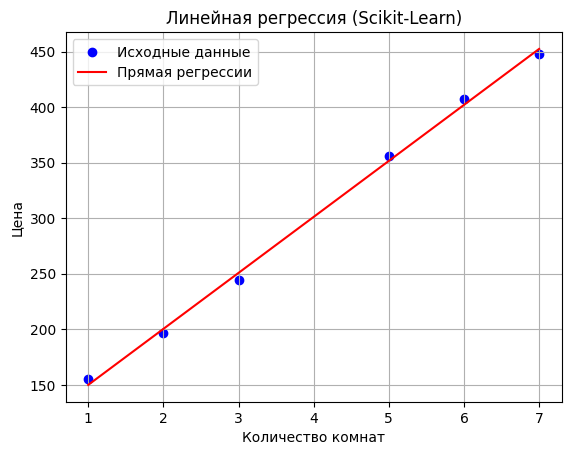

In [20]:
# Получаем предсказанные значения модели для всех исходных признаков (features)
# Это нужно, чтобы нарисовать линию регрессии
predicted_labels = model.predict(features_reshaped)

# Строим исходные точки (настоящие данные)
plt.scatter(features, labels, color='blue', label='Исходные данные')

# Строим саму прямую регрессии по предсказанным значениям
plt.plot(features, predicted_labels, color='red', label='Прямая регрессии')

# Добавляем подписи осей и заголовок
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Линейная регрессия (Scikit-Learn)')

# Добавляем легенду, чтобы отличать точки от линии
plt.legend()

# Включаем сетку на графике
plt.grid(True)

# Показываем финальный график
plt.show()

# Прогнозирование цен на жилье в Индии с помощью линейной регрессии

In [21]:
# Загрузка данных
notebook_dir = os.getcwd()  # Получаем текущую директорию ноутбука
file_path = os.path.join(notebook_dir, '..', 'data', 'Hyderabad.csv')  # Формируем путь к файлу данных (на уровень выше)
data = pd.read_csv(file_path)  # Загружаем данные из CSV-файла
data.head()  # Показываем первые 5 строк данных

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# Выводим размерность данных
num_rows, num_cols = data.shape
print("Датасет содержит", num_rows, "строк и", num_cols, "столбцов")

Датасет содержит 2518 строк и 40 столбцов


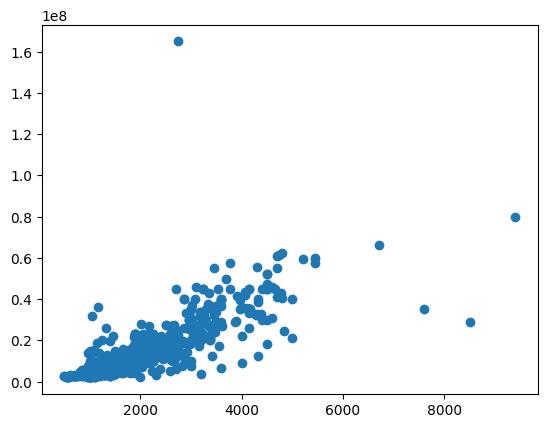

In [23]:
# Исследуем зависимость цены от площади
plt.scatter(data['Area'], data['Price'])  # Строим точечный график

In [24]:
# Подготовка данных для простой линейной регрессии (площадь -> цена)
X = data[['Area']]  # Признак: площадь (площадь в квадратных футах)
y = data['Price']  # Целевая переменная: цена (в индийских рупиях)

In [25]:
# Создаем и обучаем модель линейной регрессии
simple_model = LinearRegression()  # Создаем модель
simple_model.fit(X, y)  # Обучаем модель на данных

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
# Выводим параметры модели
print(f"Свободный член (intercept): {simple_model.intercept_}")  # Точка пересечения с осью Y
print(f"Коэффициент наклона (для площади): {simple_model.coef_[0]}")  # Коэффициент при площади

Свободный член (intercept): -6222669.083283702
Коэффициент наклона (для площади): 9753.94060818404


In [27]:
# Визуализация регрессионной линии
area_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Создаем диапазон значений площади
predicted_prices = simple_model.predict(area_range)  # Прогнозируем цены для этого диапазона

C:\Users\novos\Desktop\GitHub\grokking-machine-learning\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


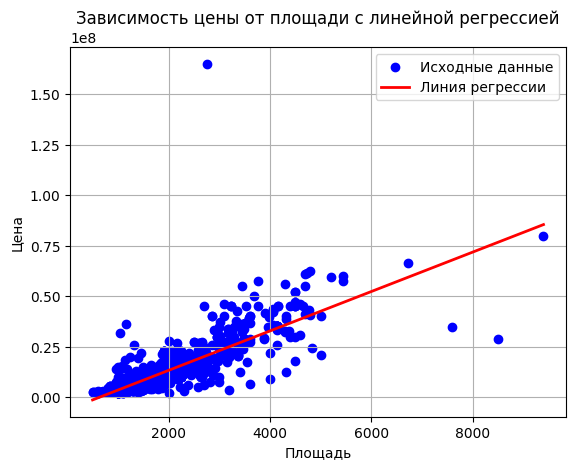

In [28]:
plt.scatter(X, y, color='blue', label='Исходные данные')  # Исходные точки данных
plt.plot(area_range, predicted_prices, color='red', linewidth=2, label='Линия регрессии')  # Линия регрессии
plt.xlabel('Площадь')  # Подпись оси X
plt.ylabel('Цена')  # Подпись оси Y
plt.title('Зависимость цены от площади с линейной регрессией')  # Заголовок
plt.legend()  # Легенда
plt.grid(True)  # Сетка
plt.show()  # Показать график

# Построение модели со всеми признаками

In [29]:
data

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [30]:
# Предварительная обработка данных:
# 1. Удаление пропущенных значений (кодированных как '9')
data_truncated = data[:2434]  # Удаляем последние строки с пропущенными значениями

In [31]:
# Масштабирование числовых признаков
data_scaled = data_truncated.copy()

# Масштабирование площади (центрирование и нормирование)
area_mean = data_scaled['Area'].mean()  # Среднее значение площади
area_std = data_scaled['Area'].std()  # Стандартное отклонение площади
data_scaled['Area'] = (data_scaled['Area'] - area_mean) / area_std  # Стандартизация

# Масштабирование количества спален
bedrooms_mean = data_scaled['No. of Bedrooms'].mean()
bedrooms_std = data_scaled['No. of Bedrooms'].std()
data_scaled['No. of Bedrooms'] = (data_scaled['No. of Bedrooms'] - bedrooms_mean) / bedrooms_std

data_scaled.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,-0.406547,Nizampet,-0.913997,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,2.477960,Hitech City,2.005515,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,-0.435953,Manikonda,-0.913997,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,-0.466696,Alwal,0.545759,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,-0.667195,Kukatpally,-0.913997,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
# One-hot кодирование категориального признака "Местоположение"
data_scaled_encoded = pd.get_dummies(data_scaled, columns=['Location'], prefix='Location', dtype=int)

In [33]:
# Разделение на признаки и целевую переменную
X_full = data_scaled_encoded.drop('Price', axis=1)  # Все признаки кроме цены
y_full = data_scaled_encoded['Price']  # Целевая переменная (цена)

In [34]:
# Создание и обучение модели
model_predict_all = LinearRegression()  # Создаем модель
model_predict_all.fit(X_full, y_full)  # Обучаем на всех признаках

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
# Вывод коэффициентов модели
print("\nКоэффициенты линейной регрессии (прогнозирование цены по всем признакам):")
print(f"Свободный член: {model_predict_all.intercept_}")
print("Коэффициенты признаков:")

counter = 1
for feature, coef in zip(X_full.columns, model_predict_all.coef_):
    print(f"{counter}.\t{feature}: {coef:.2f}")
    counter += 1


Коэффициенты линейной регрессии (прогнозирование цены по всем признакам):
Свободный член: 8947283.55419346
Коэффициенты признаков:
1.	Area: 7023504.92
2.	No. of Bedrooms: -946893.40
3.	Resale: 1243472.50
4.	MaintenanceStaff: -1009480.51
5.	Gymnasium: -566573.47
6.	SwimmingPool: -74999.96
7.	LandscapedGardens: 888197.41
8.	JoggingTrack: -617116.77
9.	RainWaterHarvesting: -499674.76
10.	IndoorGames: 381986.02
11.	ShoppingMall: 653904.51
12.	Intercom: -129946.58
13.	SportsFacility: -14343.91
14.	ATM: -267074.49
15.	ClubHouse: 379591.69
16.	School: -2597664.64
17.	24X7Security: -144163.54
18.	PowerBackup: 164439.46
19.	CarParking: -227003.39
20.	StaffQuarter: 514965.41
21.	Cafeteria: 1170792.45
22.	MultipurposeRoom: 338851.72
23.	Hospital: 1864174.84
24.	WashingMachine: 708354.33
25.	Gasconnection: 770551.94
26.	AC: 560593.55
27.	Wifi: 807040.42
28.	Children'splayarea: 816730.14
29.	LiftAvailable: -494075.18
30.	BED: 2296740.50
31.	VaastuCompliant: 252564.01
32.	Microwave: -1415563.12
33.

In [36]:
# Оценка модели
y_pred = model_predict_all.predict(X_full)  # Прогнозируем цены
mse = mean_squared_error(y_full, y_pred)  # Среднеквадратичная ошибка
rmse = np.sqrt(mse)  # Корень из среднеквадратичной ошибки
print(f"RMSE модели: {rmse:,.2f}")  # Выводим ошибку модели

RMSE модели: 3,981,396.29


In [37]:
# Прогнозирование цены для нового дома (площадь 1000, 3 спальни)
new_house_data = pd.DataFrame({'Area': [1000], 'No. of Bedrooms': [3]})

# Применяем то же масштабирование, что и для обучающих данных
new_house_data['Area'] = (new_house_data['Area'] - area_mean) / area_std
new_house_data['No. of Bedrooms'] = (new_house_data['No. of Bedrooms'] - bedrooms_mean) / bedrooms_std

# Подготовка one-hot кодирования для местоположения
location_cols = [col for col in X_full.columns if col.startswith('Location_')]
new_house_location_dummies = pd.DataFrame(0, index=new_house_data.index, columns=location_cols)

In [38]:
# Предполагаем, что дом находится в 'Gachibowli' (если такой район был в обучающих данных)
if 'Location_Gachibowli' in location_cols:
    new_house_location_dummies['Location_Gachibowli'] = 1
else:
    print("Предупреждение: район 'Gachibowli' не найден в обучающих данных")

In [39]:
# Объединяем все признаки
new_house_processed = pd.concat([new_house_data, new_house_location_dummies], axis=1)

# Добавляем недостающие колонки (заполняем нулями)
for col in X_full.columns:
    if col not in new_house_processed.columns:
        new_house_processed[col] = 0

# Упорядочиваем колонки как в обучающих данных
new_house_processed = new_house_processed[X_full.columns]

In [40]:
# Прогнозируем цену
predicted_price = model_predict_all.predict(new_house_processed)
print(f"Прогнозируемая цена для дома площадью 1000 кв.футов и 3 спальнями: {predicted_price[0]:,.2f} рупий")

Прогнозируемая цена для дома площадью 1000 кв.футов и 3 спальнями: 6,004,735.31 рупий


# Полиномиальная регрессия

Если данные не расположены на прямой - используем полиномиальную регрессию.  
Небольшое условие при обучении модели полиномиальной регрессии заключается в том, что мы должны определить степень многочлена **перед началом обучения**.

In [41]:
from models.polynomial_regression import polynomial_regression, predict_polynomial
from utils.errors import mae, mse, rmse 
from utils.reporting import format_polynomial_equation, print_prediction_poly
from utils.plotting import plot_model_poly

y = 4.0 + (3.0 * x^1)
Для x = 6 → Предсказанное значение: 22.00
MAE:	 0.0
MSE:	 0.0
RMSE:	 0.0


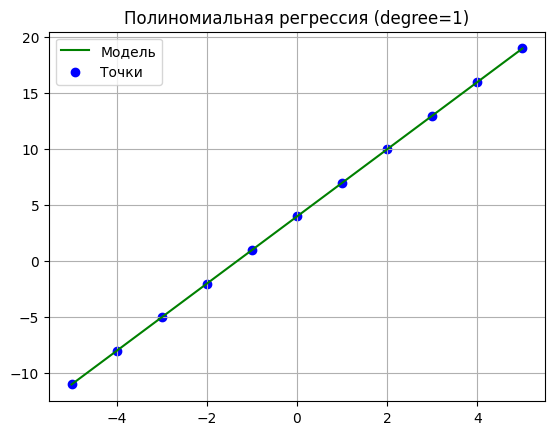

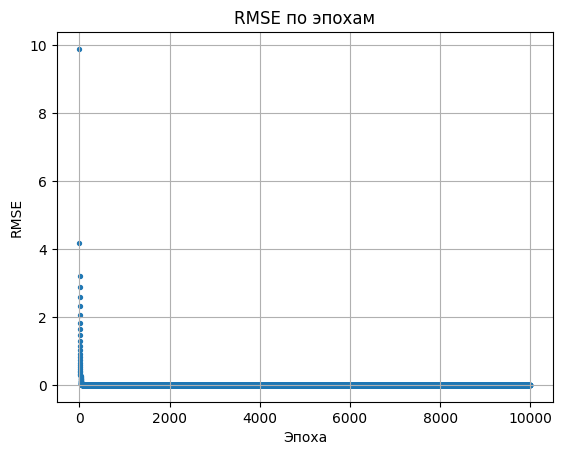

In [42]:
features = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
labels = 3 * features + 4

degree = 1
weights, errors_list = polynomial_regression(
    features, labels, degree=degree,
    learning_rate=0.01, epochs=10000,
    error='rmse', mode='batch'
)

print(format_polynomial_equation(weights))
print(print_prediction_poly(weights, degree, 6))

predictions = predict_polynomial(weights, features, degree)
print("MAE:\t", round(mae(labels, predictions), 2))
print("MSE:\t", round(mse(labels, predictions), 2))
print("RMSE:\t", round(rmse(labels, predictions), 2))

plot_model_poly(weights, degree, features, labels)
plot_errors(errors_list, "rmse")

y = -3.0 + (-2.0 * x^1) + (1.0 * x^2)
Для x = 6 → Предсказанное значение: 21.00
MAE:	 0.0
MSE:	 0.0
RMSE:	 0.0


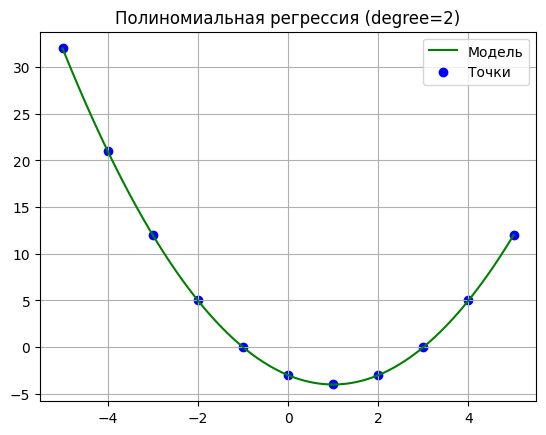

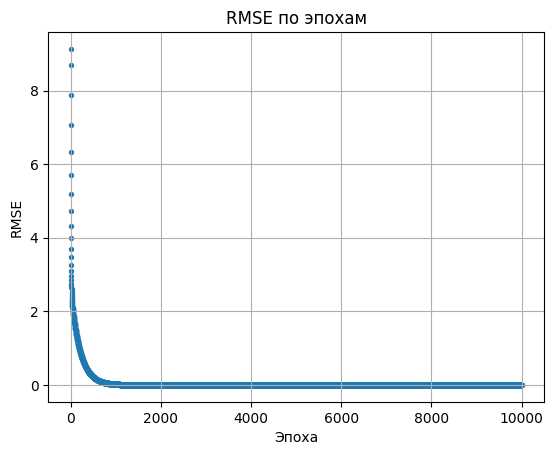

In [43]:
features = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
labels = features**2 - 2 * features - 3

degree = 2
weights, errors_list = polynomial_regression(
    features, labels, degree=degree,
    learning_rate=0.001, epochs=10000,
    error='rmse', mode='batch'
)

print(format_polynomial_equation(weights))
print(print_prediction_poly(weights, degree, 6))

predictions = predict_polynomial(weights, features, degree)
print("MAE:\t", round(mae(labels, predictions), 2))
print("MSE:\t", round(mse(labels, predictions), 2))
print("RMSE:\t", round(rmse(labels, predictions), 2))

plot_model_poly(weights, degree, features, labels)
plot_errors(errors_list, "rmse")

y = -0.99 + (-4.0 * x^1) + (2.0 * x^2) + (1.0 * x^3)
Для x = 6 → Предсказанное значение: 263.00
MAE:	 0.01
MSE:	 0.0
RMSE:	 0.01


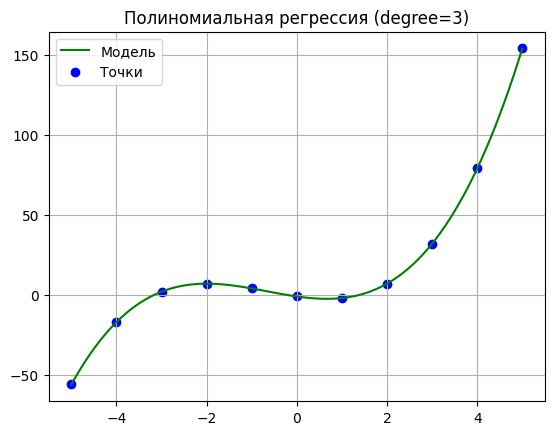

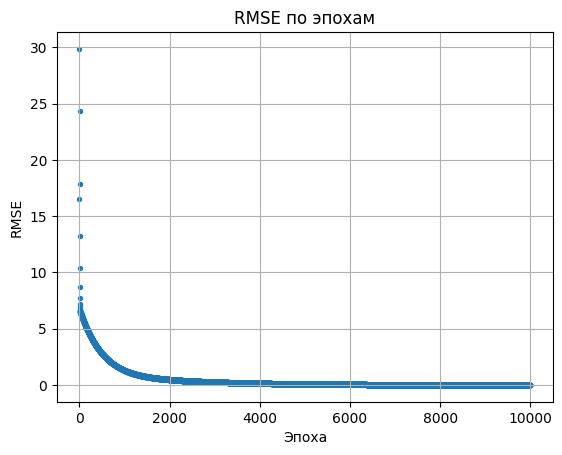

In [44]:
features = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
labels = features**3 + 2 * features**2 - 4 * features - 1

degree = 3
weights, errors_list = polynomial_regression(
    features, labels, degree=degree,
    learning_rate=0.0001, epochs=10000,
    error='rmse', mode='batch'
)

print(format_polynomial_equation(weights))
print(print_prediction_poly(weights, degree, 6))

predictions = predict_polynomial(weights, features, degree)
print("MAE:\t", round(mae(labels, predictions), 2))
print("MSE:\t", round(mse(labels, predictions), 2))
print("RMSE:\t", round(rmse(labels, predictions), 2))

plot_model_poly(weights, degree, features, labels)
plot_errors(errors_list, "rmse")